In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
import datetime # manipulating date formats
import missingno as msno # sowing missing value
import gc #

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


# 1. Data's Overview

## Loading data

In [2]:
building_metadata = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv', parse_dates=['timestamp'])
test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv', parse_dates=['timestamp'])
weather_train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv', parse_dates=['timestamp'])
weather_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv', parse_dates=['timestamp'])

In [3]:
#Transformation of the timestamp to date format
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp'])
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

In [4]:
#Function to reduction memory usage (Source code from Kaggle)
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

## Data's overview

In [5]:
print('Size of train data', train.shape)
print('Size of test data', test.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test data', weather_test.shape)
print('Size of building_metadata data', building_metadata.shape)

Size of train data (20216100, 4)
Size of test data (41697600, 4)
Size of weather_train data (139773, 9)
Size of weather_test data (277243, 9)
Size of building_metadata data (1449, 6)


Check missing data

In [6]:
#This function get for a given dataset, the number, the percentage, of the missing of each column 

def get_missing_info(df):
    num_entries = df.shape[0]*df.shape[1]
    null_entries = df.isnull().sum().sum()
    percent_empty = null_entries/num_entries*100
    num_missing = df.isna().sum()
    percent_missing = num_missing/len(df)*100
    col_modes = df.mode().loc[0]
    percent_mode = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missing_value_df = pd.DataFrame({'num_missing': num_missing,
                                     'percent_missing': percent_missing, 
                                     'mode': col_modes,
                                     'percent_mode':percent_mode
                                    })
    print('total empty percent:', percent_empty, '%')
    return(missing_value_df)

In [7]:
get_missing_info(train)
#get_missing_info(test)

total empty percent: 0.0 %


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.0,1249,0.173802
meter,0,0.0,0.0,59.659925
timestamp,0,0.0,2016-12-27 22:00:00,0.011723
meter_reading,0,0.0,0.0,9.269721


In [8]:
get_missing_info(building_metadata)

total empty percent: 21.486082355647575 %


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,3.0,18.909593
building_id,0,0.000000,0,0.069013
primary_use,0,0.000000,Education,37.888199
square_feet,0,0.000000,387638.0,0.483092
year_built,774,53.416149,1976.0,3.795721
floor_count,1094,75.500345,1.0,7.522429


In [9]:
#According to the above table, 53.41% of year_built and 75.50% 
#of floor_count are not available

#We fill the floor_count's NA by mode = 1 (repsent 7.52% of floor_count values) 
#and the year_built by the mean of it value
building_metadata.fillna({'floor_count':1,'year_built': building_metadata['year_built'].mean()}, inplace = True)
building_metadata['primary_use'] = building_metadata['primary_use'].astype('category')

In [10]:
building_metadata.isnull().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
year_built     0
floor_count    0
dtype: int64

In [11]:
get_missing_info(weather_train)
#get_missing_info(weather_test)

total empty percent: 10.876365408356566 %


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,0.0,6.284476
timestamp,0,0.000000,2016-01-01 01:00:00,0.011447
air_temperature,55,0.039350,15.0,1.947443
cloud_coverage,69173,49.489529,0.0,24.232863
dew_temperature,113,0.080845,10.0,1.973915
precip_depth_1_hr,50289,35.979052,0.0,55.740379
sea_level_pressure,10618,7.596603,1015.2,0.608844
wind_direction,6268,4.484414,0.0,9.410974
wind_speed,304,0.217496,2.1,10.288825


In [12]:
#Even the weather data don't change more in the futur and the past, so we make a 
#forward and backward filling
# First: transformation of the timestamp into a datetime object 
# Second: sorting by site id then timestamp

weather_train = weather_train.sort_values(by=['site_id', 'timestamp']) 
weather_train.fillna(method = 'ffill', inplace=True, limit = 24)#forward fill the missing data up to 12 hours
weather_train.fillna(method = 'bfill', inplace=True, limit = 24)#backfill up to 12 hours

## Weather test
weather_test = weather_test.sort_values(by=['site_id', 'timestamp']) 
weather_test.fillna(method = 'ffill', inplace=True, limit = 24)
weather_test.fillna(method = 'bfill', inplace=True, limit = 24)


<AxesSubplot:>

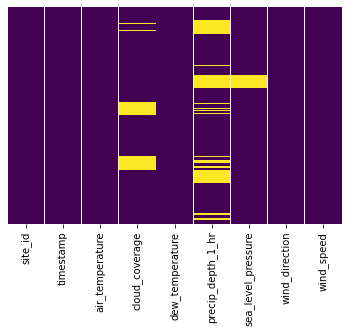

In [13]:
sns.heatmap(weather_train.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')
#sns.heatmap(weather_test.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [14]:
#Train data
missing_cols = [col for col in weather_train.columns if weather_train[col].isna().any()] 
fill_lib = weather_train.groupby('site_id')[missing_cols].transform('mean')
#stores the mean of each feature for each site id
weather_train.fillna(fill_lib, inplace=True) #for each feature with missing 
#values, fill the missing entry with the mean for that site

#Test data
missing_cols = [col for col in weather_test.columns if weather_test[col].isna().any()] 
fill_lib = weather_test.groupby('site_id')[missing_cols].transform('mean')
#stores the mean of each feature for each site id
weather_test.fillna(fill_lib, inplace=True)

weather_train.isna().sum()
#weather_test.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

## Merge data

In [15]:

train_merge = train.merge(building_metadata, on='building_id', how='left', validate='many_to_one')
test_merge = test.merge(building_metadata, on='building_id', how='left', validate='many_to_one')

train_merge = train_merge.merge(weather_train, on=['site_id', 'timestamp'], how='left', validate='many_to_one')
test_merge = test_merge.merge(weather_test, on=['site_id', 'timestamp'], how='left', validate='many_to_one')



In [16]:
del building_metadata, weather_train, weather_test, train, test
gc.collect()

45

###  Additionnal Nan before merging

In [17]:
get_missing_info(train_merge)
#get_missing_info(test_merge)

total empty percent: 0.19584174247258374 %


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.000000,1249,0.173802
meter,0,0.000000,0.000000,59.659925
timestamp,0,0.000000,2016-12-27 22:00:00,0.011723
meter_reading,0,0.000000,0.000000,9.269721
site_id,0,0.000000,13.000000,13.413878
primary_use,0,0.000000,Education,40.391094
square_feet,0,0.000000,387638.000000,0.304154
year_built,0,0.000000,1967.957037,59.990033
floor_count,0,0.000000,1.000000,87.274351
air_temperature,90495,0.447638,24.400000,1.958662


This additionnal missing values appear here because some merging identity (timesamp) of train and test dataset aren't in  weater data. 

In [18]:
#train_data
train_merge = train_merge.sort_values(by=['building_id', 'timestamp'])
train_merge.fillna(method = 'ffill', inplace=True)


#test data
test_merge = test_merge.sort_values(by=['building_id', 'timestamp'])
test_merge.fillna(method = 'ffill', inplace=True)

In [19]:
#train_merge.isna().sum()
test_merge.isna().sum()

row_id                0
building_id           0
meter                 0
timestamp             0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [20]:
train_merge = reduce_mem_usage(train_merge)
test_merge = reduce_mem_usage(test_merge)


Memory usage after optimization is: 906.14 MB
Decreased by 63.6%
Memory usage after optimization is: 1869.00 MB
Decreased by 63.6%
